# **Lab 4.1 Data Augmentation with PyTorch**

In [70]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as TF
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps


Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [83]:
def load_data(path, user_batch_size):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  
        transforms.Pad(96, padding_mode='edge'),
        transforms.RandomAffine(
            degrees=45,
            translate=(0.1, 0.1),
            scale=(0.8, 1.2),
            shear=45,
            fill=None 
        ),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
    ])
    dataset = datasets.ImageFolder(root=path, transform=transform)
    data_loader = DataLoader(dataset, user_batch_size, shuffle=True)
    return data_loader


Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/01.png?raw=true)

</details>

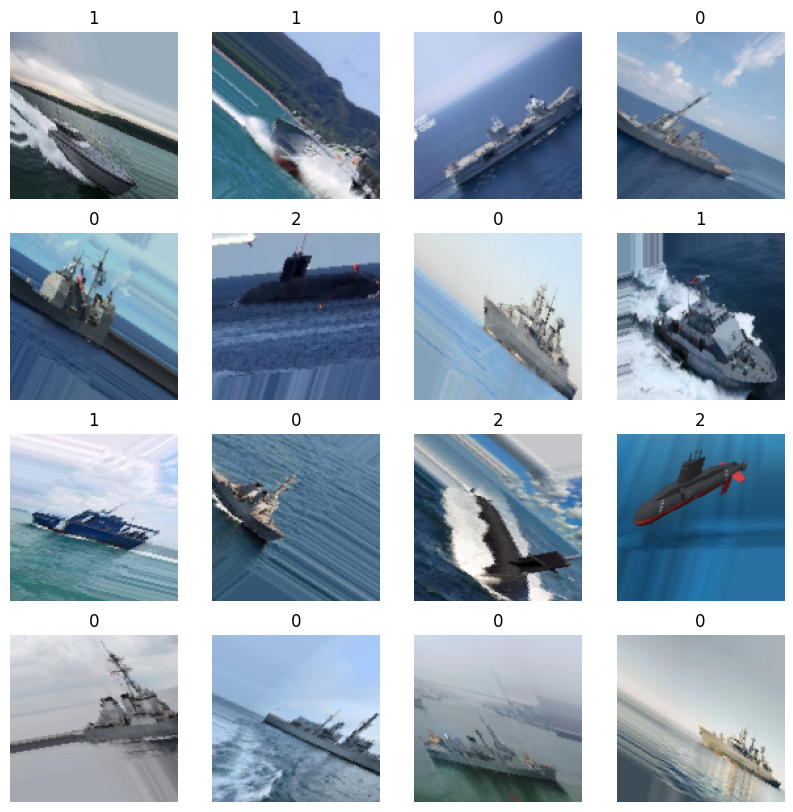

In [84]:
### START CODE HERE ###
data_loader = load_data('Ship/Ship/Train',16)

images, labels = next(iter(data_loader))

# แสดงภาพ 4x4
fig, axs = plt.subplots(4, 4, figsize=(10, 10))


for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        image = images[idx].permute(1, 2, 0).numpy()  # C,H,W → H,W,C
        axs[i, j].imshow(image)
        axs[i, j].set_title(str(labels[idx].item()))
        axs[i, j].axis('off')

plt.show()



### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [85]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self):
        pass

    def __call__(self, image):
        # Resize
        image = image.resize((128, 128))

        # Pad
        image = ImageOps.expand(image, border=128, fill=None)

        # RandomAffine
        angle = random.uniform(-45, 45)
        translate = (random.uniform(-0.1, 0.1) * image.size[0],
                     random.uniform(-0.1, 0.1) * image.size[1])
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-45, 45)
        image = TF.affine(image, angle=angle, translate=translate, scale=scale, shear=shear, fill=None)

        # Center crop
        image = TF.center_crop(image, 128)

        # ToTensor
        image = TF.to_tensor(image)

        # Gaussian Blur
        np_img = image.permute(1, 2, 0).numpy() * 255
        np_img = np_img.astype(np.uint8)
        blurred = cv2.GaussianBlur(np_img, (5, 5), 0)
        image = torch.from_numpy(blurred).float().div(255).permute(2, 0, 1)

        # Gaussian Noise
        noise = torch.randn_like(image) * 0.05
        image = torch.clamp(image + noise, 0., 1.)

        return image
    
    def load_data(path, user_batch_size):
        transform = CustomImageDataset()
        dataset = datasets.ImageFolder(root=path, transform=transform)
        data_loader = DataLoader(dataset, user_batch_size, shuffle=True)
        return data_loader

    
    
### END CODE HERE ###

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/02.png?raw=true)

</details>

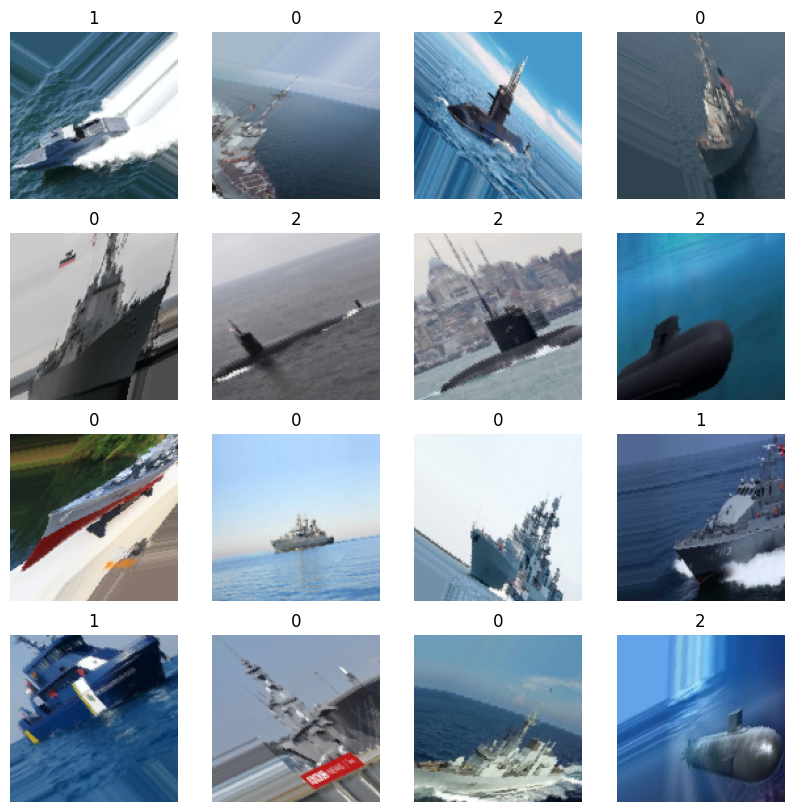

In [86]:
data_loader = load_data('Ship/Ship/Train', 16)
images, labels = next(iter(data_loader))
fig, axs = plt.subplots(4, 4, figsize=(10, 10))


for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        image = images[idx].permute(1, 2, 0).numpy()  # C,H,W → H,W,C
        axs[i, j].imshow(image)
        axs[i, j].set_title(str(labels[idx].item()))
        axs[i, j].axis('off')

plt.show()

Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?

ANS:

1. fill_mode และ padding_mode เป็นการเติมค่า pixel เมื่อเกิดช่องว่างจากการแปลงภาพ เช่นการหมุน/การยืด/การตัดภาพ ช่วยให้ภาพไม่สูญเสียข้อมูลขนาดแปลงภาพ มากจนเกินไป แต่หากใช้                  constantอาจทำให้เข้าใจผิดว่าขอบ padding นั้นเป็นเนื้อหาของภาพ หรือหากใช้ 'reflect' หรือ 'edge' มากเกินไปก็จะทำให้รูปภาพเพี้ยนได้ จึงต้องทำอย่างระมัดระวังและใช้ตัวเลขที่เหมาะสม

2. การทำ augmentation ไม่ควรทำมากเกินไป ควรทำแค่นิดหน่อย_______เพื่อไม่ให้ข้อมูลผิดเพี้ยนจากเดิมมากเกินไปแต่ยังมีความแตกต่างจากรูปต้นฉบับเล็กน้อย

3. salt-and-pepper noice สามารถทำได้โดยสุ่มพิกัด pixel ในภาพแล้วทำให้เป็น สีขาว - ดำ บาง pixel ผลลัพท์คือภาพจะดูเหมือนภาพเสีย ทำให้เพิ่มประสิทธิภาพของโมเดลด้วยการเทรนด้วยภาพที่คุณภาพต่ำ

4.  RandomPerspective() → บิดภาพเหมือนเลนส์กว้าง
    GaussianBlur() → จำลองภาพเบลอจากการโฟกัสผิด
    Custom Mask → ทำขอบมืด (vignette) หรือสีเพี้ยนด้วย NumPy/OpenCV